# Regression of aco_angle_1 from low-level data

This code regresses aco_angle_1 from the pion 4-vectors.

In [15]:
# start with some setup
!pip install --user uproot
!pip install --user lbn
import sys
sys.path.append("/eos/home-m/dwinterb/.local/lib/python2.7/site-packages")

In [16]:
import uproot 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
#import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#from keras.models import Sequential
#from keras.layers import Dense
#from keras.callbacks import EarlyStopping
#from keras.wrappers.scikit_learn import KerasRegressor
#from keras.callbacks import History
import tensorflow as tf

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#from ROOT import TLorentzVector
from lbn import LBN, LBNLayer

In [17]:
# read data files
tree_tt = uproot.open("/eos/user/k/kgalambo/SWAN_projects/Masters_CP_Kristof_2/MVAFILE_AllHiggs_tt.root")["ntuple"]
tree_et = uproot.open("/eos/user/k/kgalambo/SWAN_projects/Masters_CP_Kristof_2/MVAFILE_AllHiggs_et.root")["ntuple"]
tree_mt = uproot.open("/eos/user/k/kgalambo/SWAN_projects/Masters_CP_Kristof_2/MVAFILE_AllHiggs_mt.root")["ntuple"]

In [18]:
variables = [
    "wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand",
    "aco_angle_1", 
    "mva_dm_1", "mva_dm_2",
    "tau_decay_mode_1", "tau_decay_mode_2",
#     "ip_x_1", "ip_y_1", "ip_z_1", "ip_x_2", "ip_y_2", "ip_z_2", # ignore impact parameter for now
    "pi_E_1", "pi_px_1", "pi_py_1", "pi_pz_1",
    "pi_E_2", "pi_px_2", "pi_py_2", "pi_pz_2",
    "pi0_E_1", "pi0_px_1", "pi0_py_1", "pi0_pz_1",
    "pi0_E_2", "pi0_px_2", "pi0_py_2", "pi0_pz_2",
    "y_1_1", "y_1_2"
]

In [19]:
# WARNING! This line takes a long time
df = tree_tt.pandas.df(variables)

In [32]:
df_1 = df[
      (df["tau_decay_mode_1"] == 1) 
    & (df["tau_decay_mode_2"] == 1) 
    & (df["mva_dm_1"] == 1) 
    & (df["mva_dm_2"] == 1)
    # comment some selections to help with stats
    #& (df["deepTauVsJets_medium_1"] > 0.5) 
    #& (df["deepTauVsEle_vvloose_1"] > 0.5)
    #& (df["deepTauVsMu_vloose_1"] > 0.5)
    #& (df["deepTauVsJets_medium_2"] > 0.5) 
    #& (df["deepTauVsEle_vvloose_2"] > 0.5)
    #& (df["deepTauVsMu_vloose_2"] > 0.5)
    #& (df["trg_doubletau"] > 0.5)
]

df_1 = df_1.drop(["mva_dm_1", "mva_dm_2", "tau_decay_mode_1", "tau_decay_mode_2"], axis=1).reset_index(drop=True)

df_ps = df_1[
      (df_1["rand"]<df_1["wt_cp_ps"]/2)
]

df_sm = df_1[
      (df_1["rand"]<df_1["wt_cp_sm"]/2)
]


In [79]:
# create target labels (y)
         
# prepare the target labels - old version. In the old version, parity was y.
parity_sm = pd.DataFrame(np.ones(df_sm.shape[0]))
parity_ps = pd.DataFrame(np.zeros(df_ps.shape[0]))

parity = pd.concat([parity_sm, parity_ps])
parity.columns = ["class"]

# prepare the target variables - new version. Aco_angle_1 is y.
y_sm = df_sm["aco_angle_1"]
y_ps = df_ps["aco_angle_1"]

y = pd.DataFrame(pd.concat([y_sm, y_ps]))
y.columns = ["aco_angle_1"]

# prepare the dataframe to use in training
X = pd.concat([df_sm, df_ps])

# drop any other variables that aren't required in training
#X = X.drop(["wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand", "aco_angle_1"], axis=1).reset_index(drop=True)
X = X.drop(["wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand", "aco_angle_1", "y_1_1", "y_1_2"], axis=1).reset_index(drop=True)

print(X.columns)
print(y)
print(parity)

Index(['pi_E_1', 'pi_px_1', 'pi_py_1', 'pi_pz_1', 'pi_E_2', 'pi_px_2',
       'pi_py_2', 'pi_pz_2', 'pi0_E_1', 'pi0_px_1', 'pi0_py_1', 'pi0_pz_1',
       'pi0_E_2', 'pi0_px_2', 'pi0_py_2', 'pi0_pz_2'],
      dtype='object')
        aco_angle_1
2          3.750274
7          3.907006
8          1.669376
10         6.073213
11         2.413196
12         2.236670
14         2.338017
15         3.311521
17         2.149978
19         4.783627
21         6.259001
22         2.589150
25         3.902166
26         5.165087
29         3.400597
30         5.836054
32         5.927918
33         1.592528
34         3.521951
38         3.202050
40         4.379103
46         0.673766
48         5.085882
50         2.812382
51         0.138942
54         0.424804
56         1.931245
58         3.689418
59         4.868278
60         2.112378
...             ...
653476     3.842937
653477     0.256328
653478     2.386752
653482     0.599856
653483     3.085475
653484     0.735530
653486     1.487

In [80]:
# rescale variables so that they go between 0-1 

scaler_x = MinMaxScaler()
print(scaler_x.fit(X))
xscale=scaler_x.transform(X)

X = pd.DataFrame(xscale, columns=X.columns)

MinMaxScaler(copy=True, feature_range=(0, 1))


In [81]:
# reshape features into two 4-vectors
X = np.reshape(X.to_numpy(), (X.shape[0], 4, 4)) # must convert features input to numpy because it's difficult to reshape pandas dataframe

# split X1, X2, and y into train and validation dataset 

X_train, X_test, y_train, y_test  = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=123456,
    #stratify=y.values,
)

In [82]:
## simple dense NN
#def baseline_model():
#    # create model
#    model = Sequential()
#    model.add(Dense(len(X.columns), input_dim=len(X.columns), kernel_initializer='normal', activation='relu'))
#    model.add(Dense((len(X.columns))*2, kernel_initializer='normal', activation='relu'))
#    model.add(Dense(1))
#    model.compile(optimizer='adam', loss='mean_squared_error')  
#    return model

In [92]:
def lbn_model():
    input_shape = (4, 4)
    LBN_output_features = ["E", "px", "py", "pz", "m", "pair_dy", "pair_cos"]
    
    model = tf.keras.models.Sequential()
    model.add(LBNLayer(input_shape, 11, boost_mode=LBN.PAIRS, features=LBN_output_features))
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')  
    return model

In [84]:
## define early stopping
#early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [85]:
print(type(y_train))

<class 'pandas.core.frame.DataFrame'>


In [86]:
# convert to tensors because it seems that lbn only accepts tensor data
X_train = tf.convert_to_tensor(X_train, dtype=np.float32)
X_test = tf.convert_to_tensor(X_test, dtype=np.float32)
y_train = tf.convert_to_tensor(y_train.to_numpy(), dtype=np.float32)
y_test = tf.convert_to_tensor(y_test.to_numpy(), dtype=np.float32)

In [87]:
print(X_train)

Tensor("Const_11:0", shape=(517646, 4, 4), dtype=float32)


In [93]:
# first run the training for simple case with just 1 variable
history = tf.keras.callbacks.History()

#model = baseline_model()
model = lbn_model()

#model.fit(X_train, y_train, batch_size=10000, epochs=100, \
#          callbacks=[history], validation_data=(X_test, y_test), steps_per_epoch=50)

#X_train = X_train[:500]
#y_train = y_train[:500]

history = model.fit(X_train, y_train, epochs=50, steps_per_epoch=50)

ValueError: Tensor conversion requested dtype float32_ref for Tensor with dtype float32: 'Tensor("Adam_14/LBN_31/variables/particle_weights/m/Initializer/zeros:0", shape=(4, 11), dtype=float32)'

In [ ]:
# Extract number of run epochs from the training history
epochs = range(1, len(history.history["loss"])+1)

# Extract loss on training and validation ddataset and plot them together
plt.plot(epochs, history.history["loss"], "o-", label="Training")
plt.plot(epochs, history.history["val_loss"], "o-", label="Test")
plt.xlabel("Epochs"), plt.ylabel("Loss")
plt.yscale("log")
plt.legend();

# differencwes between the loss for training vs test implies overtraining

In [ ]:
y_pred = model.predict(X_test).flatten()

In [ ]:
try:
    y_test = y_test.to_numpy().flatten()
except:
    y_test = y_test.flatten()

In [ ]:
rmse = (np.mean((y_test-y_pred)**2))**0.5
print()
print('The RMSE is:', rmse)
r2 = r2_score(y_test, y_pred)
print('The R^2 score is:', r2)

In [ ]:
# should have the results in two lists called sm_aco and ps_aco

In [12]:
# define function to plot 'signal' vs 'background' for a specified variables
# useful to check whether a variable gives some separation between
# signal and background states
def plot_signal_background(data1, data2, column,
                        bins=100, x_uplim=0, **kwargs):

    if "alpha" not in kwargs:
        kwargs["alpha"] = 0.5

    df1 = data1[column]
    df2 = data2[column]

    fig, ax = plt.subplots()
    df1 = df1.sample(3000, random_state=1234)
    df2 = df2.sample(3000, random_state=1234)
    low = max(min(df1.min(), df2.min()),-5)
    high = max(df1.max(), df2.max())
    if x_uplim != 0: high = x_uplim

    ax.hist(df1, bins=bins, range=(low,high), **kwargs)
    ax.hist(df2, bins=bins, range=(low,high), **kwargs)
    if column == "aco_angle_1":
        plt.title('given aco_angle_1 (true values)')
    else:
        plt.title(column)
    
    if x_uplim != 0:
        ax.set_xlim(0,x_uplim)

    # ax.set_yscale('log')


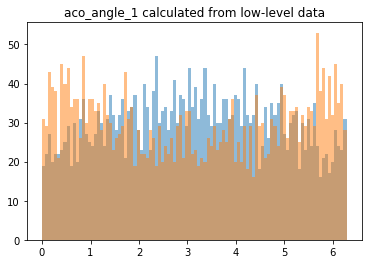

In [14]:
# plot my calculated aco_angle_1 values
sm_aco_df = pd.DataFrame(sm_aco, columns=['aco_angle_1 calculated from low-level data'])
ps_aco_df = pd.DataFrame(ps_aco, columns=['aco_angle_1 calculated from low-level data'])
plot_signal_background(sm_aco_df, ps_aco_df, 'aco_angle_1 calculated from low-level data', bins=100)

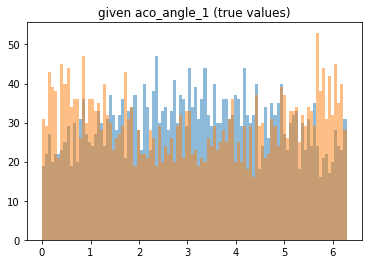

In [15]:
# plot the given aco_angle_1 values
plot_signal_background(df_sm, df_ps, 'aco_angle_1', bins=100)